# Variational Autoencoder in TensorFlow

The main motivation for this post was that I wanted to get more experience with both [Variational Autoencoders](http://arxiv.org/abs/1312.6114) (VAEs) and with [Tensorflow](http://www.tensorflow.org/). Thus, implementing the former in the latter sounded like a good idea for learning about both at the same time. This post summarizes the result.

Note: The post was updated on December 7th 2015:
  * a bug in the computation of the latent_loss was fixed (removed an erroneous factor 2). Thanks Colin Fang for pointing this out.
  * Using a Bernoulli distribution rather than a Gaussian distribution in the generator network

Let us first do the necessary imports, load the data (MNIST), and define some helper functions.

In [15]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [16]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/g3doc/tutorials/mnist/input_data.py
#import input_data
#mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
#n_samples = mnist.train.num_examples
import pickle
with open('lit_scaled_facse.pkl','rb') as f:
    faces = pickle.load(f)

In [17]:
n_samples = len(faces)

In [18]:
import numpy as np
faces_flattened = np.array([f.flatten() for f in faces])

In [19]:
faces_flattened.shape

(1670, 3584)

In [26]:
faces[0].shape

(64, 56)

In [20]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

Based on this, we define now a class "VariationalAutoencoder" with a [sklearn](http://scikit-learn.org)-like interface that can be trained incrementally with mini-batches using partial_fit. The trained model can be used to reconstruct unseen input, to generate new samples, and to map inputs to the latent space.

In [21]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluatio of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In general, implementing a VAE in tensorflow is relatively straightforward (in particular since we don not need to code the gradient computation). A bit confusing is potentially that all the logic happens at initialization of the class (where the graph is generated), while the actual sklearn interface methods are very simple one-liners.

We can now define a simple fuction which trains the VAE using mini-batches:

In [24]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        batches = np.array_split(np.random.permutation(n_samples), total_batch)
        # Loop over all batches
        for i in range(total_batch):
            #batch_xs, _ = mnist.train.next_batch(batch_size)
            batch_xs = faces_flattened[ batches[i][:batch_size], :]
            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), \
                  "cost=", "{:.9f}".format(avg_cost)
    return vae

## Illustrating reconstruction quality

We can now train a VAE on MNIST by just specifying the network topology. We start with training a VAE with a 20-dimensional latent space.

In [38]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         #n_input=784, # MNIST data input (img shape: 28*28)
         n_input = 3584,
         n_z=25)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=500, learning_rate=0.002, display_step=20)

Epoch: 0001 cost= 2209.407717768
Epoch: 0021 cost= 1840.191950084
Epoch: 0041 cost= 1819.236709686
Epoch: 0061 cost= 1814.118849703
Epoch: 0081 cost= 1797.262269894
Epoch: 0101 cost= 1785.372957698
Epoch: 0121 cost= 1775.767193640
Epoch: 0141 cost= 1770.222898929
Epoch: 0161 cost= 1763.070989369
Epoch: 0181 cost= 1766.248903560
Epoch: 0201 cost= 1757.273095411
Epoch: 0221 cost= 1761.060484012
Epoch: 0241 cost= 1755.638237685
Epoch: 0261 cost= 1755.794823926
Epoch: 0281 cost= 1753.688891748
Epoch: 0301 cost= 1751.684599551
Epoch: 0321 cost= 1750.390625000
Epoch: 0341 cost= 1749.569903162
Epoch: 0361 cost= 1749.719793811
Epoch: 0381 cost= 1745.170788794
Epoch: 0401 cost= 1743.973615269
Epoch: 0421 cost= 1741.314426810
Epoch: 0441 cost= 1746.367779578
Epoch: 0461 cost= 1743.979316757
Epoch: 0481 cost= 1743.232356089


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x1233eff90>> ignored


Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those. In general the VAE does really well.

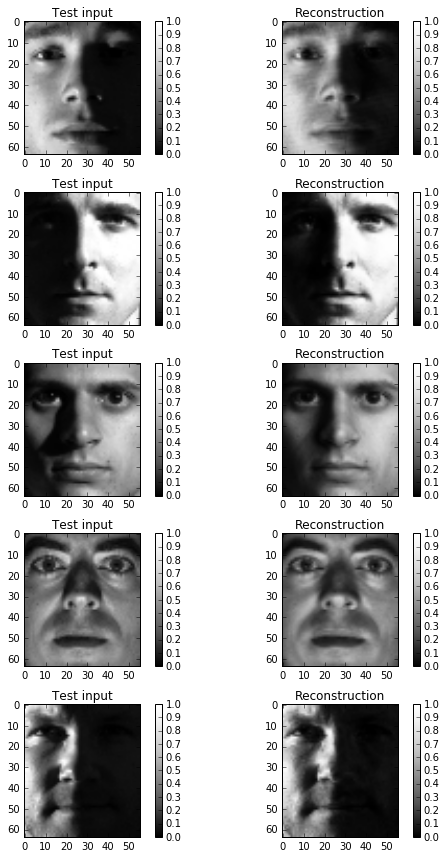

In [39]:
#x_sample = mnist.test.next_batch(100)[0]
x_sample = faces_flattened[np.random.permutation(n_samples)[:100], :]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(64, 56), vmin=0, vmax=1, cmap=plt.cm.Greys_r)
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(64, 56), vmin=0, vmax=1, cmap=plt.cm.Greys_r)
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Illustrating latent space

Next, we train a VAE with 2d latent space and illustrates how the encoder (the recognition network) encodes some of the labeled inputs (collapsing the Gaussian distribution in latent space to its mean). This gives us some insights into the structure of the learned manifold (latent space)

In [40]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=250, # 2nd layer encoder neurons
         n_hidden_gener_1=250, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         #n_input=784, # MNIST data input (img shape: 28*28)
         n_input = 3584,
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=500, learning_rate=0.002, display_step=20)

Epoch: 0001 cost= 2218.165436705
Epoch: 0021 cost= 1859.057463686
Epoch: 0041 cost= 1859.643920167
Epoch: 0061 cost= 1854.607430647
Epoch: 0081 cost= 1850.645116018
Epoch: 0101 cost= 1849.829781355
Epoch: 0121 cost= 1844.230693886
Epoch: 0141 cost= 1843.622929921
Epoch: 0161 cost= 1846.040579973
Epoch: 0181 cost= 1839.656975112
Epoch: 0201 cost= 1840.074199745
Epoch: 0221 cost= 1838.147170015
Epoch: 0241 cost= 1841.103011263
Epoch: 0261 cost= 1839.097812675
Epoch: 0281 cost= 1833.878963265
Epoch: 0301 cost= 1838.756191231
Epoch: 0321 cost= 1833.810976679
Epoch: 0341 cost= 1836.835396590
Epoch: 0361 cost= 1834.199240679
Epoch: 0381 cost= 1831.146627643
Epoch: 0401 cost= 1832.859252199
Epoch: 0421 cost= 1833.425578043
Epoch: 0441 cost= 1831.980784525
Epoch: 0461 cost= 1832.350935336
Epoch: 0481 cost= 1834.911539226


An other way of getting insights into the latent space is to use the generator network to plot reconstrunctions at the positions in the latent space for which they have been generated:

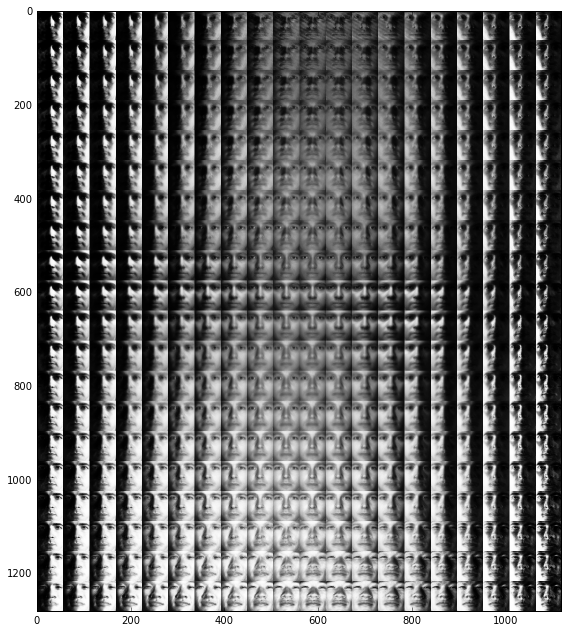

In [48]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((64*ny, 56*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.tile(np.array([[xi, yi]]), (100,1))
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*64:(nx-i)*64, j*56:(j+1)*56] = x_mean[0].reshape(64, 56)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap=plt.cm.Greys_r)
plt.tight_layout()

In [42]:
vae_2d.x_reconstr_mean

<tf.Tensor 'Sigmoid_4:0' shape=(100, 3584) dtype=float32>

## Summary
In summary, tensorflow is well suited to rapidly implement a prototype of machine learning models like VAE. The resulting code could be easily executed on GPUs as well (requiring just that tensorflow with GPU support was installed). VAE allows learning probabilistic encoders and decoders of data in an end-to-end fashion.

In [11]:
%load_ext watermark
%watermark -a "Jan Hendrik Metzen" -d -v -m -p numpy,scikit-learn

Jan Hendrik Metzen 08/12/2015 

CPython 2.7.10
IPython 4.0.0

numpy 1.10.1
scikit-learn 0.17

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.13.0-37-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
